## 프로젝트: 인물 모드 문제점 찾기
만들면서 뭔가 이상한 점이 느껴지지 않으셨나요? 프로젝트를 통해 찾아봅시다.

우선 주요 라이브러리 버전을 확인해 볼까요?

In [1]:
# importlib: 사용자가 파이썬의 import 시스템과 상호작용하기 위한 API를 제공하는 내장 라이브러리
# 사용자는 import 함수의 구현 내용과, 실행에 필요한 하위 함수들을 이용해 필요에 맞는 임포터를 직접 구현하거나 임포트 관련 기능들을 자유롭게 사용할 수 있음
# importlib.metadata: 설치된 패키지 메타 데이터에 대한 접근을 제공하는 라이브러리.
# 해당 코드 블럭에서는 importlib.metadata 안에 있는 version() 함수를 이용하여 pixellib 라이브러리의 버전을 확인

from importlib.metadata import version
import cv2
import pixellib

print(cv2.__version__)
print(version('pixellib'))

4.5.3
0.7.1


### Step 1. 인물모드 직접 해 보기
여러분의 셀카를 이용해서 오늘 배운 내용을 수행해 봅시다. 아래와 같은 이미지를 얻어야 합니다. 최소 3장 이상의 인물모드 사진을 만들어 봅시다.
인물이 주인공이 아닌, 귀여운 고양이에 대한 아웃포커싱 사진도 만들어 볼 수 있을 것입니다. 시맨틱 세그멘테이션 스텝에서 힌트를 찾아봅시다.
배경을 blur하는 인물모드 사진이 아니라 배경사진을 다른 이미지로 교체하는 크로마키 배경 합성을 시도해 볼 수도 있을 것입니다. 여러분만의 환상적인 사진을 만들어 보면 어떨까요?

#### 배경 블러 인물사진

In [2]:
# 필요한 라이브러리를 임포트합니다.
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

# 준비한 이미지를 로드합니다.
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image.png'
img_orig = cv2.imread(img_path)

In [3]:
# 시맨틱 세그멘테이션을 위한 모델을 다운로드하고 로드합니다.
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'
urllib.request.urlretrieve(model_url, model_file)
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

# 이미지에 모델을 적용하여 세그멘테이션 결과를 얻습니다.
segvalues, output = model.segmentAsPascalvoc(img_path)

In [4]:
# 사람 라벨에 해당하는 색상을 찾아내기 위한 컬러맵을 생성합니다.
colormap = np.zeros((256, 3), dtype=int)
ind = np.arange(256, dtype=int)
for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3
colormap[15] #컬러맵 15에 해당하는 배열 출력 (pacalvoc에 LABEL_NAMES 15번째인 사람)

array([192, 128, 128])

In [5]:
seg_color = (128, 128, 192)  # 사람 라벨에 해당하는 색상

(500, 892)


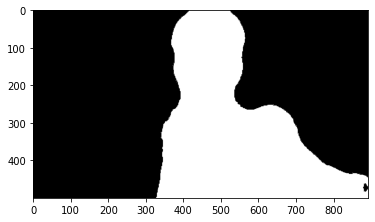

In [6]:
# 세그멘테이션 결과에서 사람 부분만 추출합니다.
seg_map = np.all(output == seg_color, axis=-1)
print(seg_map.shape)
# 배경을 흐리게 처리합니다.
img_orig_blur = cv2.blur(img_orig, (26, 26))
plt.imshow(seg_map, cmap='gray')
plt.show()

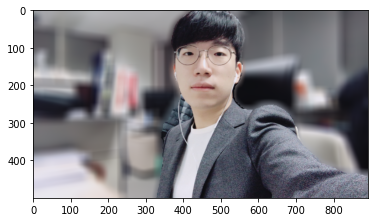

In [7]:
# 세그멘테이션 마스크를 이용하여 배경과 인물 영상을 합성합니다.
img_mask_color = cv2.cvtColor(seg_map.astype(np.uint8) * 255, cv2.COLOR_GRAY2BGR)
img_bg_blur = cv2.bitwise_and(img_orig_blur, cv2.bitwise_not(img_mask_color))
img_concat = np.where(img_mask_color == 255, img_orig, img_bg_blur)

# 최종 결과를 시각화합니다.
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

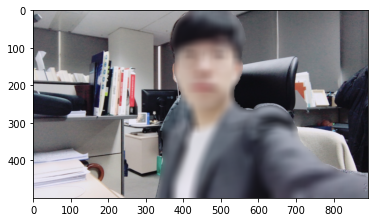

In [9]:
img_concat = np.where(img_mask_color == 255, img_orig_blur, img_orig)

# 최종 결과를 시각화합니다.
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

#### 배경 블러 고양이 사진

In [16]:
# 준비한 이미지를 로드합니다.
img_path = os.getenv('HOME')+'/aiffel/Aiffel_Quest/Exploration10/Images/Cat.jpg'
img_orig = cv2.imread(img_path)

# 이미지에 모델을 적용하여 세그멘테이션 결과를 얻습니다.
segvalues, output = model.segmentAsPascalvoc(img_path)

In [17]:
#pascalvoc 데이터의 라벨종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)
print(LABEL_NAMES.index('cat'))

8


In [18]:
# 고양이 라벨에 해당하는 색상을 찾아내기 위한 컬러맵을 생성합니다.
colormap = np.zeros((256, 3), dtype=int)
ind = np.arange(256, dtype=int)
for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[8] #컬러맵 8에 해당하는 배열 출력 (pacalvoc에 LABEL_NAMES 8번째인 고양이)

array([64,  0,  0])

In [19]:
seg_color = (0, 0, 64)  # 사람 라벨에 해당하는 색상

(528, 559)


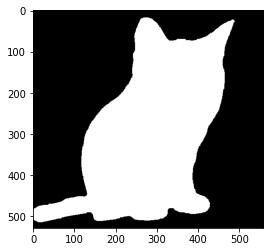

In [20]:
# 세그멘테이션 결과에서 고양이 부분만 추출합니다.
seg_map = np.all(output == seg_color, axis=-1)
print(seg_map.shape)
# 배경을 흐리게 처리합니다.
img_orig_blur = cv2.blur(img_orig, (26, 26))
plt.imshow(seg_map, cmap='gray')
plt.show()

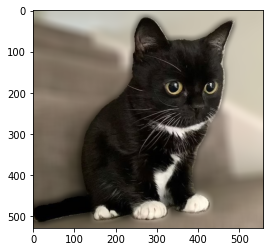

In [22]:
# 세그멘테이션 마스크를 이용하여 배경과 고양이 영상을 합성합니다.
img_mask_color = cv2.cvtColor(seg_map.astype(np.uint8) * 255, cv2.COLOR_GRAY2BGR)
img_bg_blur = cv2.bitwise_and(img_orig_blur, cv2.bitwise_not(img_mask_color))
img_concat = np.where(img_mask_color == 255, img_orig, img_bg_blur)

# 최종 결과를 시각화합니다.
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

#### 크로마키 배경 합성 인물사진

In [40]:
# 준비한 이미지를 로드합니다.
img_path = os.getenv('HOME')+'/aiffel/Aiffel_Quest/Exploration10/Images/jisoo.jpg'
img_path_2 = os.getenv('HOME')+'/aiffel/Aiffel_Quest/Exploration10/Images/universe.jpg'
img_orig = cv2.imread(img_path)
img_orig_back = cv2.imread(img_path_2)
img_orig_back_resized =  cv2.resize(img_orig_back, (img_orig.shape[1], img_orig.shape[0]))
# 이미지에 모델을 적용하여 세그멘테이션 결과를 얻습니다.
segvalues, output = model.segmentAsPascalvoc(img_path)

In [41]:
print(img_orig.shape)
print(img_orig_back_resized.shape)


(466, 700, 3)
(466, 700, 3)


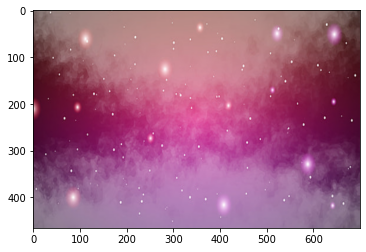

In [43]:
plt.imshow(img_orig_back_resized)
plt.show()

In [25]:
#pascalvoc 데이터의 라벨종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)
print(LABEL_NAMES.index('person'))

15


In [26]:
# 사람 라벨에 해당하는 색상을 찾아내기 위한 컬러맵을 생성합니다.
colormap = np.zeros((256, 3), dtype=int)
ind = np.arange(256, dtype=int)
for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[15] #컬러맵 8에 해당하는 배열 출력 (pacalvoc에 LABEL_NAMES 15번째인 사람)

array([192, 128, 128])

In [27]:
seg_color = (128, 128, 192)  # 사람 라벨에 해당하는 색상

(466, 700)


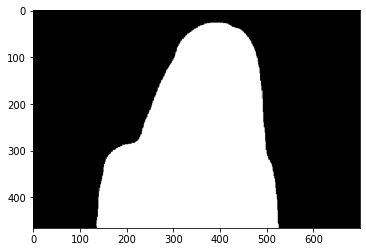

In [29]:
# 세그멘테이션 결과에서 고양이 부분만 추출합니다.
seg_map = np.all(output == seg_color, axis=-1)
print(seg_map.shape)
# 배경을 흐리게 처리합니다.
# img_orig_blur = cv2.blur(img_orig, (26, 26))
plt.imshow(seg_map, cmap='gray')
plt.show()

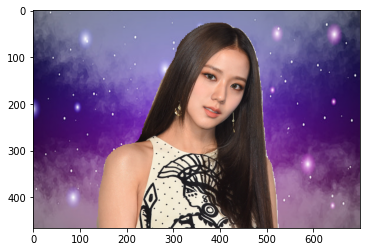

In [44]:
# 세그멘테이션 마스크를 이용하여 배경과 고양이 영상을 합성합니다.
img_mask_color = cv2.cvtColor(seg_map.astype(np.uint8) * 255, cv2.COLOR_GRAY2BGR)
# img_bg_blur = cv2.bitwise_and(img_orig_blur, cv2.bitwise_not(img_mask_color))
img_concat = np.where(img_mask_color == 255, img_orig, img_orig_back_resized)

# 최종 결과를 시각화합니다.
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

### Step 2. 사진에서 문제점 찾기
그러나 여러분들의 사진에는 무언가 문제점이 있을 것입니다.

아래 사진에도 문제점이 몇 가지 있었습니다. 예를 들어 뒤에 걸린 옷이 인물 영역에 포함되어 blur되지 않고 나온다던가 하는 경우입니다. ㅠㅠ 그 외 다른 문제들이 눈에 띄시나요? 아래 사진에는 이상한 점이 최소 2개 이상 더 있습니다. 어떤 문제가 있는지 찾아서 아래 사진처럼 표시해 봅시다.

추가로 여러분이 만들어 낸 인물 모드 사진 중 하나에서도 이상한 위치를 찾아 아래 사진처럼 표시해 봅시다. 표시한 이미지들을 jupyter notebook에 포함하여 제출해 주세요.

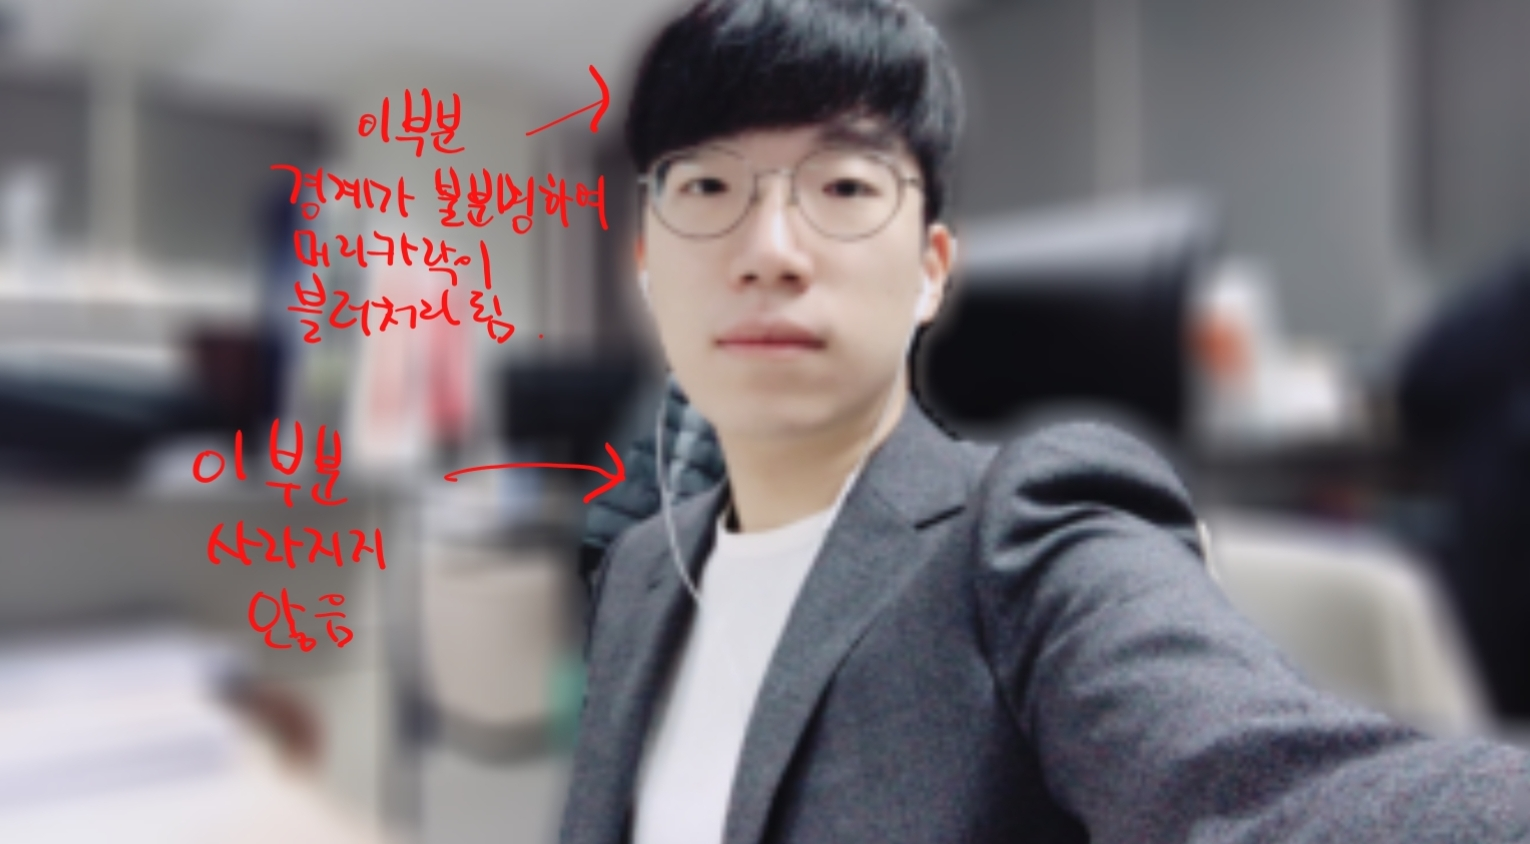

### Step 3. 해결 방법을 제안해 보기
아주 간단히 멋진 카메라 앱 서비스를 만들어 출시할 수 있을 것 같았지만, 지금 같은 완성도로는 어림도 없습니다. 소비자들의 눈높이는 그리 호락호락하지 않고, 엔지니어인 여러분들은 답을 찾아내야 합니다.

#### 문제점 :
1. Semantic segmentation의 부정확성으로 인해 사람이 아닌 부분까지 사람으로 인식한 문제가 있습니다.
2. 경계가 불분명하여 머리카락 부분까지 블러 처리 되었습니다.

#### 솔루션 :
- 이러한 부분은 사람과 가까이 있으면서 옷 색깔과 비슷한 픽셀까지 인식한 오류로 이는 앞선 노드에서 소개 되었던 워터쉐드 세그멘테이션을 이용하면 옷 색상의 차이를 좀더 정밀하게 나눌 수 있을 것으로 기대됩니다. 옷 색상이 뒤에 나온 패딩의 색깔보다 연한 점을 이용하여 충분히 구분 가능하다고 생각합니다.
- IR 기반의 깊이 감지 기술을 이용하면, 특히 인물과 배경 사이의 미세한 경계선을 더욱 정밀하게 처리할 수 있습니다. 이는 복잡한 배경이나 인물의 복잡한 윤곽에서 특히 중요합니다.

## 평가문항	
1. 인물모드 사진을 성공적으로 제작하였다.	
상세기준 : 아웃포커싱 효과가 적용된 인물모드 사진과 동물 사진, 배경전환 크로마키사진을 각각 1장 이상 성공적으로 제작하였다.


2. 제작한 인물모드 사진들에서 나타나는 문제점을 정확히 지적하였다.	
상세기준 : 인물사진에서 발생한 문제점을 정확히 지적한 사진을 제출하였다.


3. 인물모드 사진의 문제점을 개선할 수 있는 솔루션을 적절히 제시하였다.	
상세기준 : semantic segmentation mask의 오류를 보완할 수 있는 좋은 솔루션을 이유와 함께 제시하였다.

### 회고
이전 과정에서 더 나아가 필터를 적용하고 원본과 필터 적용된 이미지를 합성하는 것을 배웠습니다.
과정이 진행됨에 따라 하나씩 하나씩 배워 나감을 느꼈고, 이번 과정에서는 저번 과제 때보다 더 다양한 시도를 해볼 수 있었습니다.
또한 여러 문제점을 발견하고, 문제점에 대한 해결 방안을 모색하면서 더 다양한 기법들에 대해 알게 된 좋은 시간이었습니다.
다만, 이번에는 저번처럼 함수화 과정을 진행하지 못해 아쉬움이 남습니다.